In [ ]:
import os
os.environ["FIREWORKS_API_KEY"] = "PASTE_YOUR_API"


In [ ]:
import os, json, time, shutil

# --- Paths ---
project = "/content/drive/MyDrive/ML_Project/self-instruct-main"
data_dir = f"{project}/data"
seed_file = f"{data_dir}/seed_tasks.jsonl"  # initial 175 human-written seeds
output_root = f"{data_dir}/machine_generations"
os.makedirs(output_root, exist_ok=True)

# --- Config ---
batches = 25          # total batches
per_batch = 20        # instructions per batch
engine = "accounts/fireworks/models/llama-v3p1-8b-instruct"
num_prompt_instructions = 8  # default prompt examples per generation

# --- Start from seed ---
current_seed = seed_file

for i in range(batches):
    batch_dir = f"{output_root}/batch_{i+1}"
    merged_file = f"{output_root}/merged_{i+1}.jsonl"

    print(f"\n Starting batch {i+1}/{batches}")
    print(f"Using seed file: {current_seed}")

    os.makedirs(batch_dir, exist_ok=True)

    # Run generation
    cmd = (
        f"python3 {project}/self_instruct/bootstrap_instructions.py "
        f"--batch_dir {batch_dir} "
        f"--seed_tasks_path {current_seed} "
        f"--engine {engine} "
        f"--num_instructions_to_generate {per_batch} "
        f"--num_prompt_instructions {num_prompt_instructions}"
    )

    print(f"Running: {cmd}\n")
    exit_code = os.system(cmd)
    print("Exit code:", exit_code)

    # Check output
    batch_file = os.path.join(batch_dir, "machine_generated_instructions.jsonl")
    if not os.path.exists(batch_file):
        raise FileNotFoundError(f" No output file found in {batch_dir}")

    # --- Merge seeds + new ---
    with open(current_seed, "r") as fin:
        seed_data = [json.loads(line) for line in fin]

    with open(batch_file, "r") as fin:
        new_data = [json.loads(line) for line in fin]

    all_data = seed_data + new_data

    with open(merged_file, "w") as fout:
        for obj in all_data:
            fout.write(json.dumps(obj) + "\n")

    print(f"Batch {i+1} complete. Merged {len(all_data)} total instructions → {merged_file}")

    # Use merged file as next seed
    current_seed = merged_file

    time.sleep(10)  # prevent rate limits

print("\n All batches completed successfully!")
print(f"Final merged dataset: {current_seed}")



 Starting batch 1/25
Using seed file: /content/drive/MyDrive/ML_Project/self-instruct-main/data/seed_tasks.jsonl
Running: python3 /content/drive/MyDrive/ML_Project/self-instruct-main/self_instruct/bootstrap_instructions.py --batch_dir /content/drive/MyDrive/ML_Project/self-instruct-main/data/machine_generations/batch_1 --seed_tasks_path /content/drive/MyDrive/ML_Project/self-instruct-main/data/seed_tasks.jsonl --engine accounts/fireworks/models/llama-v3p1-8b-instruct --num_instructions_to_generate 20 --num_prompt_instructions 8

Exit code: 0
Batch 1 complete. Merged 195 total instructions → /content/drive/MyDrive/ML_Project/self-instruct-main/data/machine_generations/merged_1.jsonl

 Starting batch 2/25
Using seed file: /content/drive/MyDrive/ML_Project/self-instruct-main/data/machine_generations/merged_1.jsonl
Running: python3 /content/drive/MyDrive/ML_Project/self-instruct-main/self_instruct/bootstrap_instructions.py --batch_dir /content/drive/MyDrive/ML_Project/self-instruct-main/d

In [ ]:
import json

input_path = "/content/drive/MyDrive/ML_Project/self-instruct-main/data/classify_batch_1/is_clf_or_not_llama-v3p1-8b-instruct.jsonl"
clf_output = "/content/drive/MyDrive/ML_Project/self-instruct-main/data/classification_tasks.jsonl"
nonclf_output = "/content/drive/MyDrive/ML_Project/self-instruct-main/data/non_classification_tasks.jsonl"

clf, nonclf = [], []

with open(input_path, "r") as f:
    for line in f:
        try:
            obj = json.loads(line)
            instr = obj.get("instruction", "").strip()
            label = obj.get("is_classification", "").strip().lower()

            if label == "yes":
                clf.append({"instruction": instr})
            elif label == "no":
                nonclf.append({"instruction": instr})
        except Exception as e:
            print(f"Skipping malformed line: {e}")

with open(clf_output, "w") as f:
    for x in clf:
        f.write(json.dumps(x) + "\n")

with open(nonclf_output, "w") as f:
    for x in nonclf:
        f.write(json.dumps(x) + "\n")

print(f"Split complete!")
print(f"Classification tasks: {len(clf)}")
print(f"Non-classification tasks: {len(nonclf)}")
print(f"Files saved:\n - {clf_output}\n - {nonclf_output}")


Split complete!
Classification tasks: 227
Non-classification tasks: 294
Files saved:
 - /content/drive/MyDrive/ML_Project/self-instruct-main/data/classification_tasks.jsonl
 - /content/drive/MyDrive/ML_Project/self-instruct-main/data/non_classification_tasks.jsonl


In [ ]:
!python3 /content/drive/MyDrive/ML_Project/self-instruct-main/self_instruct/generate_instances.py \
  --batch_dir /content/drive/MyDrive/ML_Project/self-instruct-main/data \
  --input_file non_classification_tasks.jsonl \
  --generation_tasks_only \
  --output_file generation_finetune_ready_clean.jsonl \
  --engine "accounts/fireworks/models/llama-v3p1-8b-instruct" \
  --request_batch_size 2 \
  --api_key $FIREWORKS_API_KEY

Generating generation instances:   3% 10/294 [00:15<07:23,  1.56s/it]API Request Failed (Attempt 1/3): 429 Client Error: Too Many Requests for url: https://api.fireworks.ai/inference/v1/chat/completions. Retrying in 10s.
API Request Failed (Attempt 2/3): 429 Client Error: Too Many Requests for url: https://api.fireworks.ai/inference/v1/chat/completions. Retrying in 20s.
Generating generation instances:   7% 22/294 [01:03<09:48,  2.16s/it]API Request Failed (Attempt 1/3): 429 Client Error: Too Many Requests for url: https://api.fireworks.ai/inference/v1/chat/completions. Retrying in 10s.
API Request Failed (Attempt 1/3): 429 Client Error: Too Many Requests for url: https://api.fireworks.ai/inference/v1/chat/completions. Retrying in 10s.
API Request Failed (Attempt 2/3): 429 Client Error: Too Many Requests for url: https://api.fireworks.ai/inference/v1/chat/completions. Retrying in 20s.
Generating generation instances:  12% 34/294 [02:00<11:04,  2.56s/it]API Request Failed (Attempt 1/3):

In [ ]:
!python3 /content/drive/MyDrive/ML_Project/self-instruct-main/self_instruct/cleanup_finetune_dataset.py \
--input_files /content/drive/MyDrive/ML_Project/self-instruct-main/data/classification_finetune_ready_clean.jsonl \
              /content/drive/MyDrive/ML_Project/self-instruct-main/data/generation_finetune_ready_clean.jsonl \
--output_file /content/drive/MyDrive/ML_Project/self-instruct-main/data/final_finetune_dataset.jsonl \
--shuffle


Reading /content/drive/MyDrive/ML_Project/self-instruct-main/data/classification_finetune_ready_clean.jsonl
Processing classification_finetune_ready_clean.jsonl: 1890it [00:00, 47212.90it/s]
Reading /content/drive/MyDrive/ML_Project/self-instruct-main/data/generation_finetune_ready_clean.jsonl
Processing generation_finetune_ready_clean.jsonl: 388it [00:00, 13158.92it/s]

Loaded 2275 valid examples (from 2278 raw).
Shuffled data.

Cleaned dataset saved → /content/drive/MyDrive/ML_Project/self-instruct-main/data/final_finetune_dataset.jsonl
Total samples: 2275
Classification tasks: 227
Generation tasks: 2048
Avg input length: 23.2 words
Avg output length: 10.4 words


In [ ]:
# =========================================
# Qwen2.5-0.5B-Instruct — QLoRA Fine-Tuning (Optimized Final)
# =========================================
!pip uninstall -y wandb -q

import os, json, random, torch
from datasets import Dataset

# ---------- Environment setup ----------
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.cuda.empty_cache()

# ---------- Load subset ----------
dataset_path = "/content/drive/MyDrive/ML_Project/self-instruct-main/data/gpt3_generations/batch_221203/all_instances_82K.jsonl"

with open(dataset_path, "r", encoding="utf-8") as f:
    data = [json.loads(l) for l in f]

data = [d for d in data if "instruction" in d and "output" in d]
random.seed(42)
data = random.sample(data, 1000)

def to_text(ex):
    instr, inp, out = ex["instruction"].strip(), ex.get("input", "").strip(), ex["output"].strip()
    if inp:
        text = (
            f"<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n"
            f"<|im_start|>user\n{instr}\n\nInput:\n{inp}<|im_end|>\n"
            f"<|im_start|>assistant\n{out}<|im_end|>"
        )
    else:
        text = (
            f"<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n"
            f"<|im_start|>user\n{instr}<|im_end|>\n"
            f"<|im_start|>assistant\n{out}<|im_end|>"
        )
    return {"text": text}

ds = Dataset.from_list(data).map(to_text, remove_columns=list(data[0].keys()))
ds = ds.train_test_split(test_size=0.05, seed=42)
train_data, val_data = ds["train"], ds["test"]

print(f"Dataset ready: {len(train_data)} train, {len(val_data)} val")

# ---------- Model ----------
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model

model_name = "Qwen/Qwen2.5-0.5B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4"
)

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"]
)
model = get_peft_model(model, lora_config)

# ---------- Trainer ----------
from trl import SFTTrainer
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/qwen05b-qlora-ft",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    learning_rate=2e-4,
    logging_steps=1,
    disable_tqdm=False,
    fp16=True,
    save_strategy="no",
    report_to="none",
    optim="paged_adamw_8bit",
)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    formatting_func=lambda e: e["text"],
    peft_config=lora_config,
)

print("\nStarting fine-tuning...\n")
trainer.train()

# ---------- Save ----------
save_dir = "/content/qwen05b-qlora-ft/adapter"
os.makedirs(save_dir, exist_ok=True)
trainer.model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
print("\nTraining complete! LoRA adapter saved to:", save_dir)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset ready: 950 train, 50 val


/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:2027: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:278: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/950 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)



Starting fine-tuning...



Step,Training Loss
1,2.798600
2,3.312600
3,3.162500
4,3.383600
5,2.775500
6,2.593800
7,2.641800
8,2.240600
9,2.493600
10,2.462300



Training complete! LoRA adapter saved to: /content/qwen05b-qlora-ft/adapter


Loading fine-tuned QLoRA model...
Loading evaluation data...
Loaded 252 evaluation instructions.

Generating QLoRA predictions for all examples (252)...


Generating: 100%|██████████| 252/252 [16:23<00:00,  3.90s/it]



Saved QLoRA predictions to: /content/drive/MyDrive/ML_Project/self-instruct-main/human_eval/predictions/qwen05b-qlora-ft_eval_predictions.jsonl

Loading Davinci outputs for comparison...
Loaded 252 valid Davinci outputs.

Computing individual metrics (QLoRA vs Davinci)...


  0%|          | 0/252 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 252/252 [00:57<00:00,  4.38it/s]



===== Aggregated Scores (QLoRA vs Davinci) =====
BLEU: 0.0696
ROUGE-L: 0.1961
BERTScore_F1: 0.8358

Saved all metrics to: /content/drive/MyDrive/ML_Project/self-instruct-main/human_eval/results/qlora_vs_davinci_all_metrics.json


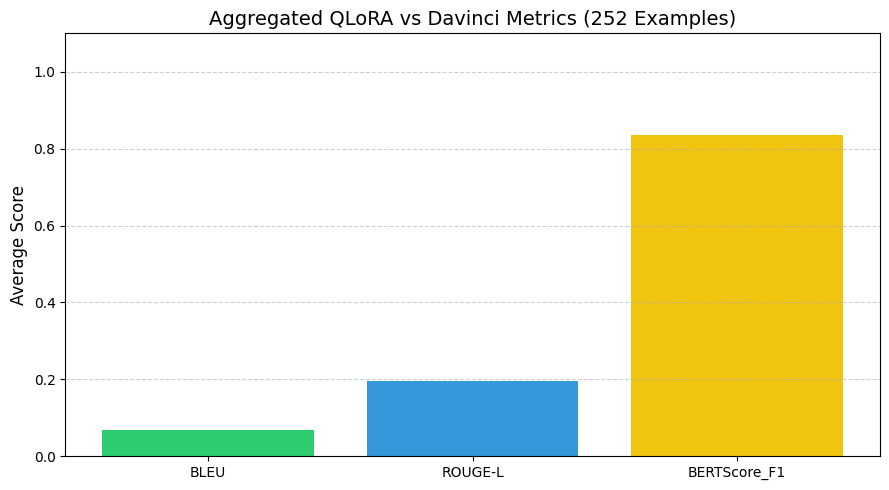


Plotting per-example variation...


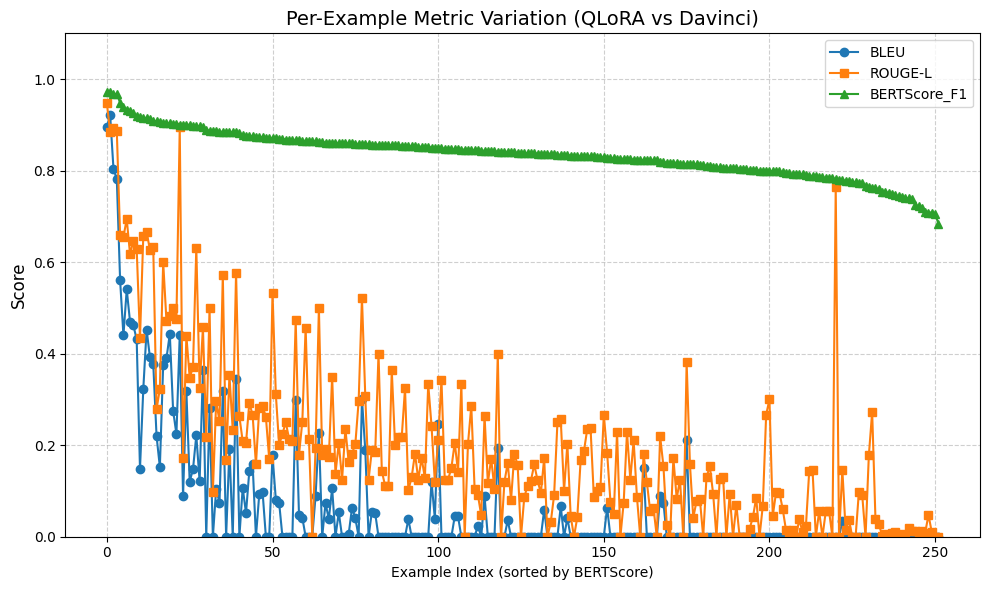


Evaluation complete and visualized successfully!

Creating side-by-side comparison of QLoRA vs Davinci (252 examples)...
Plotting QLoRA vs Davinci (per example)...


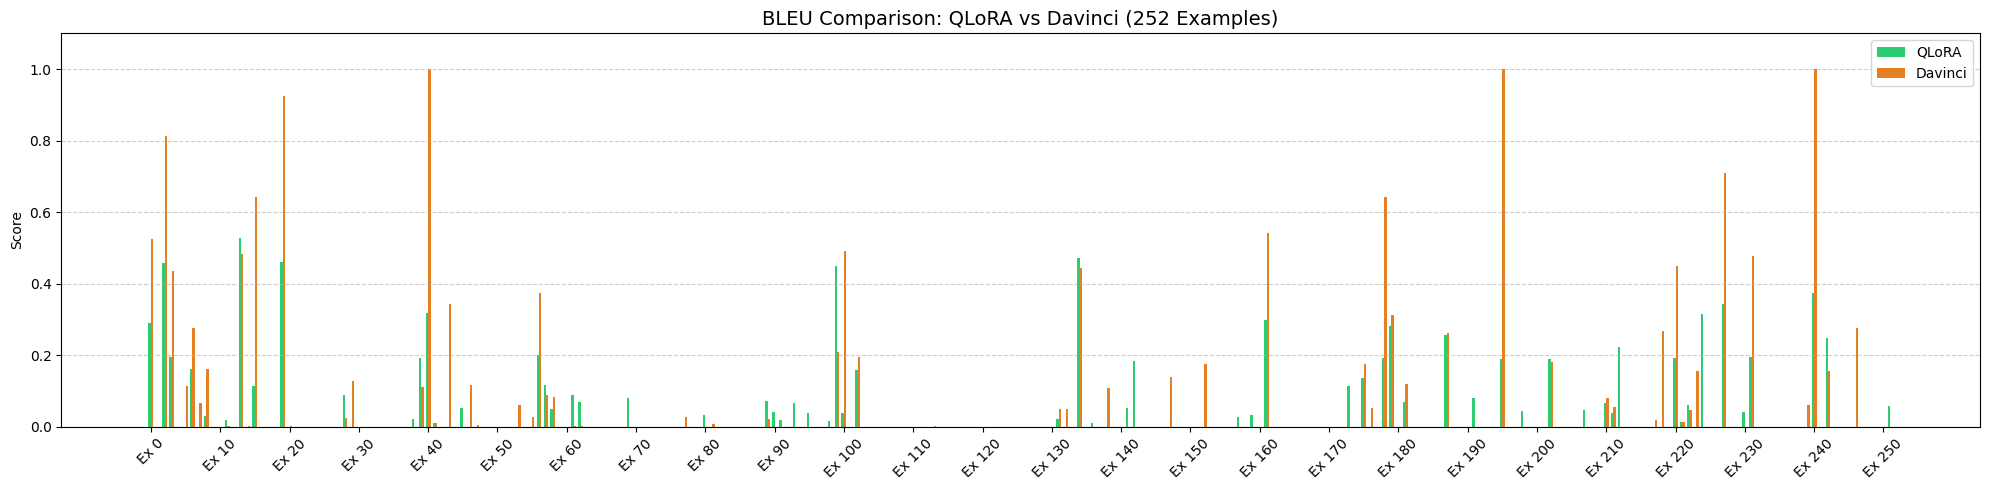

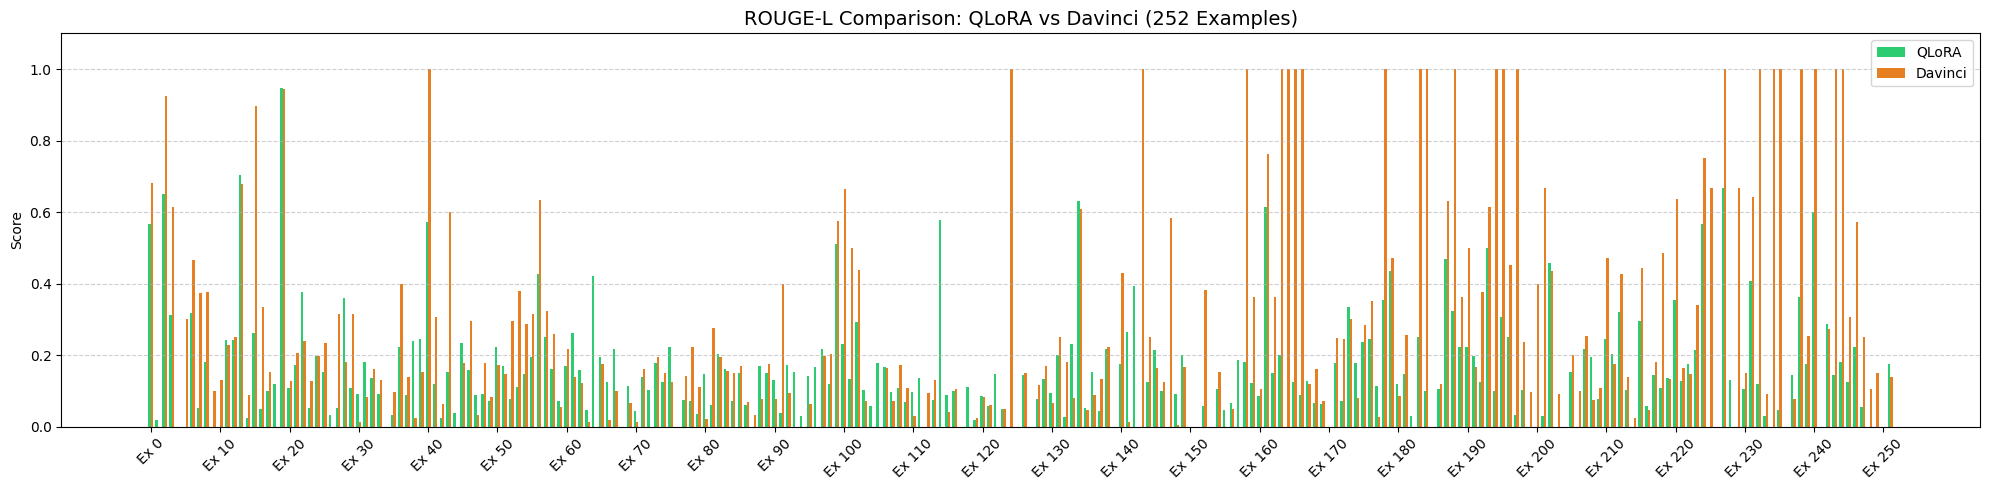

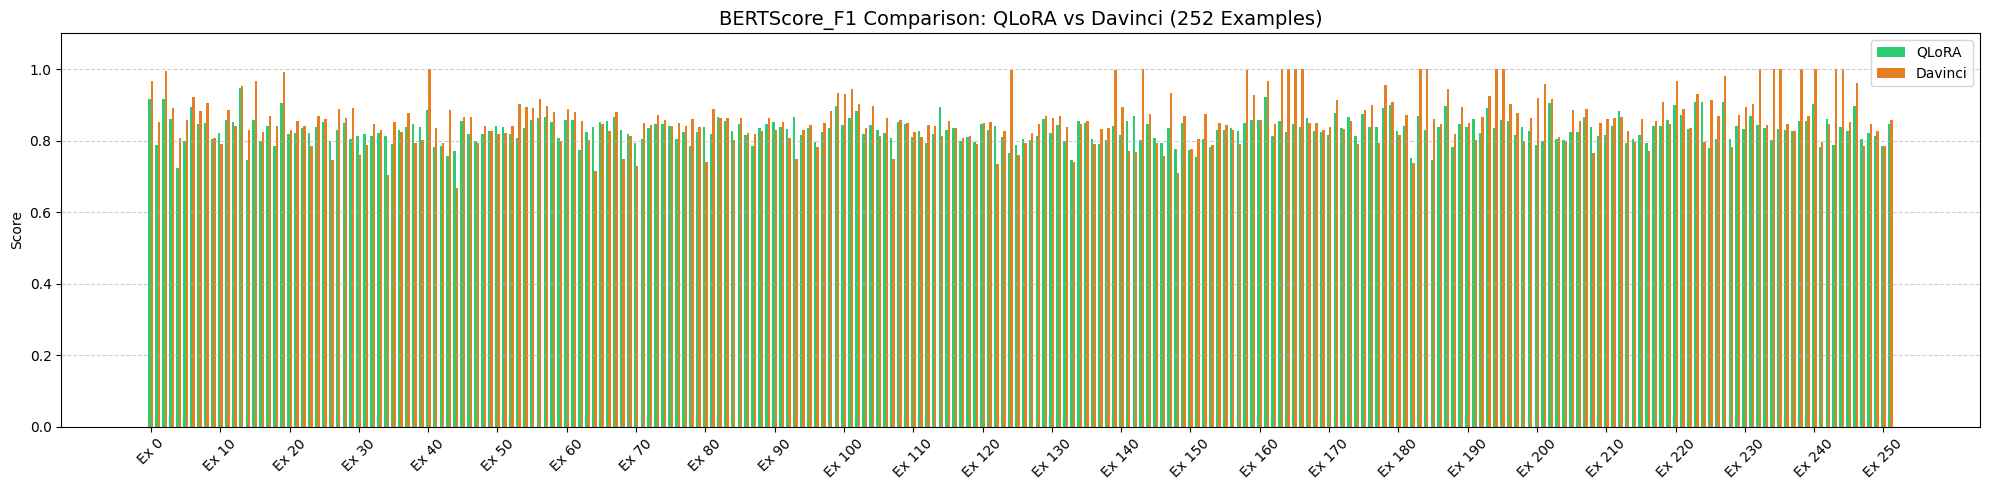


All plots saved to: /content/drive/MyDrive/ML_Project/self-instruct-main/human_eval/results/plots
Full 252-example side-by-side comparison complete!


In [32]:
# ============================================
# QLoRA vs Davinci Evaluation (252 Examples + Saved Charts)
# ============================================

!pip install -q evaluate rouge_score bert_score matplotlib

import os, json, torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel
import evaluate
import matplotlib.pyplot as plt
import numpy as np

# ---------- Paths ----------
base_path = "/content/drive/MyDrive/ML_Project/self-instruct-main/human_eval"
adapter_dir = "/content/qwen05b-qlora-ft/adapter"
eval_file = os.path.join(base_path, "user_oriented_instructions.jsonl")
davinci_file = os.path.join(base_path, "predictions/davinci-self-instruct_predictions.jsonl")
pred_file = os.path.join(base_path, "predictions/qwen05b-qlora-ft_eval_predictions.jsonl")
results_file = os.path.join(base_path, "results/qlora_vs_davinci_all_metrics.json")
plots_dir = os.path.join(base_path, "results/plots")

os.makedirs(os.path.dirname(pred_file), exist_ok=True)
os.makedirs(os.path.dirname(results_file), exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

# ---------- Load Model ----------
print("Loading fine-tuned QLoRA model...")

base_model = "Qwen/Qwen2.5-0.5B-Instruct"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(base_model, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

base = AutoModelForCausalLM.from_pretrained(
    base_model,
    device_map="auto",
    torch_dtype=torch.float16,
    quantization_config=bnb_config
)
model = PeftModel.from_pretrained(base, adapter_dir)
model.eval()

# ---------- Load Evaluation Data ----------
print("Loading evaluation data...")
eval_data = []
with open(eval_file, "r", encoding="utf-8") as f:
    for line in f:
        j = json.loads(line)
        inst = j.get("instruction", "").strip()
        instances = j.get("instances", [])
        if instances and isinstance(instances, list) and len(instances) > 0:
            inp = (instances[0].get("input") or "").strip()
            out = (instances[0].get("output") or "").strip()
            if out:
                eval_data.append({"instruction": inst, "input": inp, "output": out})

print(f"Loaded {len(eval_data)} evaluation instructions.")

# ---------- Generate QLoRA Predictions ----------
print("\nGenerating QLoRA predictions for all examples (252)...")
preds = []
for ex in tqdm(eval_data, desc="Generating"):
    instr = ex["instruction"]
    inp = ex["input"]

    if inp:
        prompt = f"<|im_start|>user\n{instr}\n\nInput:\n{inp}<|im_end|>\n<|im_start|>assistant\n"
    else:
        prompt = f"<|im_start|>user\n{instr}<|im_end|>\n<|im_start|>assistant\n"

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id
        )

    pred_text = tokenizer.decode(output[0], skip_special_tokens=True)
    pred_text = pred_text.replace(instr, "").strip()
    preds.append(pred_text)

# Save predictions
with open(pred_file, "w", encoding="utf-8") as f:
    for p in preds:
        f.write(json.dumps({"prediction": p}) + "\n")

print(f"\nSaved QLoRA predictions to: {pred_file}")

# ---------- Load Davinci Outputs ----------
print("\nLoading Davinci outputs for comparison...")
davinci_refs = []
human_refs = []
with open(davinci_file, "r", encoding="utf-8") as f:
    for line in f:
        j = json.loads(line)
        resp = j.get("response", "").strip()
        tgt = j.get("target", "").strip()
        if resp and tgt:
            davinci_refs.append(resp)
            human_refs.append(tgt)

davinci_refs = davinci_refs[:len(preds)]
human_refs = human_refs[:len(preds)]

print(f"Loaded {len(davinci_refs)} valid Davinci outputs.")

# ---------- Compute Individual Metrics ----------
print("\nComputing individual metrics (QLoRA vs Davinci)...")

bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")
bert_metric = evaluate.load("bertscore")

individual_scores = []
for i, (p, r) in enumerate(tqdm(zip(preds, davinci_refs), total=len(preds))):
    if not p.strip() or not r.strip():
        continue

    bleu = bleu_metric.compute(predictions=[p], references=[[r]])["bleu"]
    rouge = rouge_metric.compute(predictions=[p], references=[r])["rougeL"]
    bert = bert_metric.compute(predictions=[p], references=[r], lang="en")["f1"][0]

    individual_scores.append({
        "index": i,
        "QLoRA_pred": p,
        "Davinci_ref": r,
        "BLEU": bleu,
        "ROUGE-L": rouge,
        "BERTScore_F1": bert
    })

# ---------- Aggregated Averages ----------
avg_scores = {
    "BLEU": np.mean([s["BLEU"] for s in individual_scores]),
    "ROUGE-L": np.mean([s["ROUGE-L"] for s in individual_scores]),
    "BERTScore_F1": np.mean([s["BERTScore_F1"] for s in individual_scores])
}

print("\n===== Aggregated Scores (QLoRA vs Davinci) =====")
for k, v in avg_scores.items():
    print(f"{k}: {v:.4f}")

# Save all
with open(results_file, "w", encoding="utf-8") as f:
    json.dump({"aggregated": avg_scores, "individual": individual_scores}, f, indent=2)

print(f"\nSaved all metrics to: {results_file}")

# ---------- Visualization 1: Aggregated ----------
plt.figure(figsize=(9, 5))
plt.bar(avg_scores.keys(), avg_scores.values(), color=["#2ecc71", "#3498db", "#f1c40f"])
plt.title("Aggregated QLoRA vs Davinci Metrics (252 Examples)", fontsize=14)
plt.ylabel("Average Score", fontsize=12)
plt.ylim(0, 1.1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "aggregated_metrics.png"))
plt.show()

# ---------- Visualization 2: Per-Example Variation ----------
print("\nPlotting per-example variation...")
scores_sorted = sorted(individual_scores, key=lambda x: x["BERTScore_F1"], reverse=True)
x = list(range(len(scores_sorted)))

plt.figure(figsize=(10, 6))
plt.plot(x, [s["BLEU"] for s in scores_sorted], label="BLEU", marker="o")
plt.plot(x, [s["ROUGE-L"] for s in scores_sorted], label="ROUGE-L", marker="s")
plt.plot(x, [s["BERTScore_F1"] for s in scores_sorted], label="BERTScore_F1", marker="^")

plt.title("Per-Example Metric Variation (QLoRA vs Davinci)", fontsize=14)
plt.xlabel("Example Index (sorted by BERTScore)")
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "per_example_variation.png"))
plt.show()

print("\nEvaluation complete and visualized successfully!")

# ============================================
# Side-by-Side Comparison: QLoRA vs Davinci
# ============================================

print("\nCreating side-by-side comparison of QLoRA vs Davinci (252 examples)...")

qlora_scores = []
davinci_scores = []

for i, (human_ref, q_pred, d_pred) in enumerate(zip(human_refs, preds, davinci_refs)):
    if not human_ref.strip():
        continue

    bleu_q = bleu_metric.compute(predictions=[q_pred], references=[[human_ref]])["bleu"]
    rouge_q = rouge_metric.compute(predictions=[q_pred], references=[human_ref])["rougeL"]
    bert_q = bert_metric.compute(predictions=[q_pred], references=[human_ref], lang="en")["f1"][0]

    bleu_d = bleu_metric.compute(predictions=[d_pred], references=[[human_ref]])["bleu"]
    rouge_d = rouge_metric.compute(predictions=[d_pred], references=[human_ref])["rougeL"]
    bert_d = bert_metric.compute(predictions=[d_pred], references=[human_ref], lang="en")["f1"][0]

    qlora_scores.append({"BLEU": bleu_q, "ROUGE-L": rouge_q, "BERTScore_F1": bert_q})
    davinci_scores.append({"BLEU": bleu_d, "ROUGE-L": rouge_d, "BERTScore_F1": bert_d})

# ----- Visualization -----
print("Plotting QLoRA vs Davinci (per example)...")

n_show = 252
indices = np.arange(n_show)
width = 0.35
metrics = ["BLEU", "ROUGE-L", "BERTScore_F1"]
colors = {"QLoRA": "#2ecc71", "Davinci": "#e67e22"}

for metric in metrics:
    plt.figure(figsize=(20, 5))
    q_vals = [qlora_scores[i][metric] for i in range(n_show)]
    d_vals = [davinci_scores[i][metric] for i in range(n_show)]

    plt.bar(indices - width/2, q_vals, width, label="QLoRA", color=colors["QLoRA"])
    plt.bar(indices + width/2, d_vals, width, label="Davinci", color=colors["Davinci"])

    plt.xticks(indices[::10], [f"Ex {i}" for i in range(0, n_show, 10)], rotation=45)
    plt.ylabel("Score")
    plt.title(f"{metric} Comparison: QLoRA vs Davinci (252 Examples)", fontsize=14)
    plt.ylim(0, 1.1)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, f"{metric.lower()}_comparison.png"))
    plt.show()

print(f"\nAll plots saved to: {plots_dir}")
print("Full 252-example side-by-side comparison complete!")
